In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
import math
import scipy as sp
from nltk.corpus import stopwords
import scipy
import scipy.io.wavfile

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [4]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [5]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [6]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [7]:
def mini_print(out_cols, out_rows):
    out_line = PrettyTable(out_cols)
    print(" & ".join(out_cols))
    if type(out_rows[0]) == list or type(out_rows[0]) == tuple:
        for row in out_rows:
            out_line.add_row(row)
            print(" & ".join(map(str, row)))
    else:
        out_line.add_row(out_rows)
        print(" & ".join(map(str, out_rows)))
    print(out_line)

In [8]:
def gen_seg_wav(segid, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    
    fid = (segid.split('.')[0]).strip()
    segid_only = int((segid.split('.')[1]).strip())+1
    next_segid = "{0:s}.{1:03d}".format(fid, segid_only)
    
    all_segs = sorted(list(segment_map[fid].keys()))
    indx_segid = all_segs.index(segid)
        
    sid_fname = os.path.join(pair_wavs_path, "%s.wav" % segid)
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")

    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    
    wav_start = segment_map[fid][segid]
    start_time = "{0:0.2f}".format(wav_start/100)
    
    #if next_segid in segment_map[fid]:
    if (indx_segid+1) < len(all_segs):
        wav_end = segment_map[fid][all_segs[indx_segid+1]]
        print(wav_start, wav_end)
        end_time = "={0:0.2f}".format(wav_end/100)
        subprocess.call(["sox", merge_wav_fname, sid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    else:
        print(wav_start)
        subprocess.call(["sox", merge_wav_fname, sid_fname, \
                     "trim", start_time])
    
    return sid_fname

In [9]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [10]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    #print(display_pp.get_html_string())

    

In [11]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+------------------------+---------------------------------------------------+
| pair id |  nid  |     ES transcript      |                   EN translation                  |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19997 | CINCO OCHO CUATRO SEIS |                FIVE EIGHT FOUR SIX                |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19998 | CINCO OCHO CUATRO SEIS | EH SEE FOUR THE ONLY THING WANT KNOW IS THAT THAT |
|         |       |                        |   THE PHONE IS RIGHT FOUR EIGHT THREE FIVE EIGHT  |
|         |       |                        |  FOUR SIX IS THE MOST IMPORTANT THING BECAUSE THE |
|         |       |                        |                  WASHINGTON CODE                  |
+---------+-------+------------------------+---------------------------------------------------+


## Matches - cross call vs in call

In [12]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)

In [13]:
eval_df['in_uttr'] = eval_df.apply(lambda r: nodes_dict[r.n1].seg == nodes_dict[r.n2].seg, axis=1)

In [14]:
eval_df['x_call'] = eval_df.apply(lambda r: nodes_dict[r.n1].file != nodes_dict[r.n2].file, axis=1)

In [15]:
eval_df['x_uttr'] = eval_df.apply(lambda r: (nodes_dict[r.n1].file == nodes_dict[r.n2].file) and \
                                  (nodes_dict[r.n1].seg != nodes_dict[r.n2].seg), axis=1)

In [16]:
len(eval_df[eval_df.in_uttr]) + len(eval_df[eval_df.x_uttr]) + len(eval_df[eval_df.x_call])

26604

In [17]:
eval_cols = ["\#", "in_uttr", "x_uttr", "x_call"]
eval_row_tot = ["tot."]
eval_row_corr = ["corr."]
for catg in eval_cols[1:]:
    eval_row_tot.append(len(eval_df[eval_df[catg]]))
    eval_row_corr.append(len(eval_df[(eval_df[catg] == True) & (eval_df.es_cnt_sim > 0)]))

eval_row_ratio = ["\% tot."] + ["{0:.0f}\%".format(tot/len(eval_df)*100) for tot in eval_row_tot[1:]]
eval_row_pr = ["\% corr."] + ["{0:.0f}\%".format(corr/tot*100) for corr, tot in \
                             zip(eval_row_corr[1:], eval_row_tot[1:])]
mini_print(eval_cols, [eval_row_tot, eval_row_ratio, eval_row_corr, eval_row_pr])

\# & in_uttr & x_uttr & x_call
tot. & 628 & 4454 & 21522
\% tot. & 2\% & 17\% & 81\%
corr. & 488 & 2331 & 1612
\% corr. & 78\% & 52\% & 7\%
+----------+---------+--------+--------+
|    \#    | in_uttr | x_uttr | x_call |
+----------+---------+--------+--------+
|   tot.   |   628   |  4454  | 21522  |
| \% tot.  |   2\%   |  17\%  |  81\%  |
|  corr.   |   488   |  2331  |  1612  |
| \% corr. |   78\%  |  52\%  |  7\%   |
+----------+---------+--------+--------+


## Pseudotext analysis

In [18]:
train_segment_list_fname, dev_segment_list_fname

(u'../files-train.txt', u'../files-dev.txt')

In [19]:
train_fids = []
train_sids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
        train_sids.append(line.strip())
train_fids = set(train_fids)
train_sids = set(train_sids)

In [20]:
dev_segment_list_fname

u'../files-dev.txt'

In [21]:
dev_fids = []
dev_sids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
        dev_sids.append(line.strip())
dev_fids = set(dev_fids)
dev_sids = set(dev_sids)

In [22]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
clusters_stats['oov'] = []
clusters_stats['cross_seg'] = []
clusters_stats['cross_file'] = []
clusters_stats['same_seg'] = []
clusters_stats['in_vocab'] = []
for sids in clusters_stats['sids']:
    is_in_dev = len(dev_sids & set(sids)) > 0
    is_in_train = len(train_sids & set(sids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)
    clusters_stats['oov'].append(is_in_dev and not is_in_train)
    clusters_stats['in_vocab'].append(is_in_dev and is_in_train)
    cross_seg = False
    cross_file = False
    same_seg = False
    if is_in_dev and is_in_train:
        common_sids = (dev_sids & set(sids)) | (train_sids & set(sids))
        cross_seg = (len(common_sids) > 1)
        cross_file = (len(set([s.split('.')[0] for s in common_sids])) > 1)
        
    if is_in_dev or is_in_train:
        same_seg = (len(set(sids)) == 1)
        
    clusters_stats['cross_seg'].append(cross_seg)
    clusters_stats['cross_file'].append(cross_file)
    clusters_stats['same_seg'].append(same_seg)
        
        

clusters_stats['dev_depth'] = []
clusters_stats['train_depth'] = []
for nlist in clusters_stats['sids']:
    clusters_stats['dev_depth'].append(len([i for i in nlist if i in dev_sids]))
    clusters_stats['train_depth'].append(len([i for i in nlist if i in train_sids]))


In [23]:
num_oov = sum([i for i in clusters_stats['oov']])
print(num_oov)
sum_oov = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['oov'][i]])
total_pwords = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['is_dev'][i]])
print(sum_oov)
print(total_pwords)

1029
1749
4685


In [24]:
def oov_summary(dev_sids, feats_dict):
    dev_words = []
    train_words = []
    oov_pwords = []
    for did in dev_sids:
        dev_words.extend([w.decode('utf-8') for w in feats_dict[did]])
    for tid in train_sids:
        train_words.extend([w.decode('utf-8') for w in feats_dict[tid]])
    set_train_words = set(train_words)
    oov_words = [cid for cid in dev_words if cid not in set_train_words and cid != "-1"]
    missing_train_words = [cid for cid in train_words if cid == "-1"]
    missing_words = [cid for cid in dev_words if cid == "-1"]
    out_cols = ["trn wrds", "trn vocab", "dev wrds", "dev vocab", "oov", "oov types", \
                "miss trn", "miss dev", "oov + miss"]
    out_rows = [len(train_words), len(set(train_words)), len(dev_words), len(set(dev_words)), \
                len(oov_words), len(set(oov_words)), len(missing_train_words), len(missing_words), \
                len(oov_words) + len(missing_words)]
    mini_print(out_cols, out_rows)
    return Counter(train_words), Counter(dev_words), Counter(oov_words)

In [25]:
train_pwords, dev_pwords, oov_pwords = oov_summary(dev_sids, feats_dict)
train_gold_words, dev_gold_words, oov_gold_words = oov_summary(dev_sids, gold_feats_dict)

trn wrds & trn vocab & dev wrds & dev vocab & oov & oov types & miss trn & miss dev & oov + miss
34904 & 14019 & 5915 & 3577 & 1749 & 1029 & 6738 & 1230 & 2979
+----------+-----------+----------+-----------+------+-----------+----------+----------+------------+
| trn wrds | trn vocab | dev wrds | dev vocab | oov  | oov types | miss trn | miss dev | oov + miss |
+----------+-----------+----------+-----------+------+-----------+----------+----------+------------+
|  34904   |   14019   |   5915   |    3577   | 1749 |    1029   |   6738   |   1230   |    2979    |
+----------+-----------+----------+-----------+------+-----------+----------+----------+------------+
trn wrds & trn vocab & dev wrds & dev vocab & oov & oov types & miss trn & miss dev & oov + miss
59793 & 8750 & 10965 & 2944 & 1338 & 1003 & 0 & 0 & 1338
+----------+-----------+----------+-----------+------+-----------+----------+----------+------------+
| trn wrds | trn vocab | dev wrds | dev vocab | oov  | oov types | miss tr

In [26]:
oov_ratio = [420/4072, 719/4129, 601/2052, 892/2029]
for oov in oov_ratio:
    print("{0:.0f}\%".format(oov*100), end=" & ")

10\% & 17\% & 29\% & 44\% & 

In [27]:
mt_gold_pred_dict[5]['001.001']
mt_pseudo_pred_dict[5]['001.001']
feats_dict['001.001']

['8']

In [28]:
len(dev_pwords), len(set(dev_pwords))

(3577, 3577)

In [29]:
k = 1
pred_count = 0
missing_count = 0
for pw in dev_pwords:
    if pw == "-1":
        print("haha", dev_pwords["-1"])
    elif pw not in pseudo_probs_dict:
        missing_count += dev_pwords[pw]
    else:
        pred_count += (len(pseudo_probs_dict[pw].values()[:k])*dev_pwords[pw])
print(pred_count,missing_count)
print(sum([mt_pseudo_eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)]))
print(sum([len(mt_pseudo_pred_dict[k][sid]) for sid in set(dev_sids)]))
print(sum([1 for sid in dev_sids if len(mt_pseudo_pred_dict[k][sid]) > 0]))
print(sum([1 for sid in dev_sids if len(mt_pseudo_pred_dict[k][sid]) == 0]))
print(sum([1 for sid in dev_sids if feats_dict[sid] == ["-1"]]))
print(sum(dev_pwords.values()))
len(dev_sids), len(train_sids)
print(" &".join(["{0:.0f}\%".format(miss/tot * 100) for tot, miss in [(8055,4093), (911,513), \
                                                             (8094,4131), (872,475)]]))

haha 1230
2932 1753
2932
2932
1006
1470
1230
5915
51\% &56\% &51\% &54\%


In [30]:
len([cid for cid in train_pwords if cid != -1]), len(clusters_stats['most_common'])

(14019, 15533)

In [31]:
for c in [cid for cid in train_pwords if cid != -1]:
    if int(c) >= len(clusters_stats['most_common']):
        print(c)

15533


In [32]:
train_pwords_es = Counter([clusters_stats['most_common'][int(cid)-1].upper() for cid in train_pwords if cid != -1])
dev_pwords_es = Counter([clusters_stats['most_common'][int(cid)-1].upper() for cid in dev_pwords if cid != -1])
oov_pwords_es = Counter([clusters_stats['most_common'][int(cid)-1].upper() for cid in oov_pwords if cid != -1])

In [33]:
out_cols = ["train/dev/oov", "total", "types"]
out_rows = []
out_rows.append(['train', sum(train_pwords_es.values()), len(train_pwords_es)])
out_rows.append(['dev', sum(dev_pwords_es.values()), len(dev_pwords_es)])
out_rows.append(['oov', sum(oov_pwords_es.values()), len(oov_pwords_es)])
mini_print(out_cols, out_rows)

train/dev/oov & total & types
train & 14019 & 3260
dev & 3577 & 1421
oov & 1029 & 598
+---------------+-------+-------+
| train/dev/oov | total | types |
+---------------+-------+-------+
|     train     | 14019 |  3260 |
|      dev      |  3577 |  1421 |
|      oov      |  1029 |  598  |
+---------------+-------+-------+


In [34]:
sum(train_pwords_es.values()) + sum(dev_pwords_es.values()) + sum(oov_pwords_es.values())

18625

In [35]:
inv_words = [cid for cid in set(dev_pwords) - set(oov_pwords)]
print("dev pwords in train vocab: %d" % len(inv_words))
missing_translations = [cid for cid in inv_words if cid not in pseudo_probs_dict]
print("translations missing for: %d" %len(missing_translations))

dev pwords in train vocab: 2548
translations missing for: 5


In [36]:
def recall_summary(eval_dict, dev_sids, feats_dict, oov_words, k):
    num_en_oov = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_inv_and_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) > 0])
    num_only_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_en = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids)])
    num_en_missing = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if feats_dict[sid] == ['-1']])

    num_en_pred = sum([eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)])
    num_en_corr_pred = sum([eval_dict['dev'][k][sid]['cp'] for sid in set(dev_sids)])

    out_cols = ["total en", "en oov", "en missing", "upper bound recall"]
    out_rows = [num_en, num_en_oov, num_en_missing, "{0:.3f}".format((num_en-num_en_oov-num_en_missing)/num_en)]

    mini_print(out_cols, out_rows)

    out_cols = ["k", "\\# corr.", "\\# pred", "prec.", "rec.", "rec. w/o miss.", "rec. w/o oov", "rec. w/o miss.+oov"]
    out_rows = map(lambda v: "{0:.2f} \%".format(v*100) if type(v) != int else v, \
                   [k, num_en_corr_pred, num_en_pred, (num_en_corr_pred/num_en_pred), (num_en_corr_pred/num_en), num_en_corr_pred/(num_en-num_en_missing), \
                    num_en_corr_pred/(num_en-num_en_oov), num_en_corr_pred/(num_en-num_en_missing-num_en_oov)])
    mini_print(out_cols, out_rows)
    mini_print(['inv+oov', 'only oov'], [num_inv_and_oov, num_only_oov])

In [37]:
k=5
recall_summary(mt_pseudo_eval_dict, dev_sids, feats_dict, oov_pwords, k)

total en & en oov & en missing & upper bound recall
11589 & 1172 & 3346 & 0.610
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|  11589   |  1172  |    3346    |       0.610        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
5 & 320 & 11078 & 2.89 \% & 2.76 \% & 3.88 \% & 3.07 \% & 4.53 \%
+---+----------+---------+---------+---------+----------------+--------------+--------------------+
| k | \# corr. | \# pred |  prec.  |   rec.  | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+---+----------+---------+---------+---------+----------------+--------------+--------------------+
| 5 |   320    |  11078  | 2.89 \% | 2.76 \% |    3.88 \%     |   3.07 \%    |      4.53 \%       |
+---+----------+---------+---------+---------+----------------+--------------+-----

In [38]:
recall_summary(mt_gold_eval_dict, dev_sids, gold_feats_dict, oov_gold_words, k)
'''
The impact of oov words is less in the case of gold features, 
as other words in the utterances still make predictions. 

However, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when
oov words are encountered
'''

total en & en oov & en missing & upper bound recall
11589 & 76 & 0 & 0.993
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|  11589   |   76   |     0      |       0.993        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
5 & 5809 & 25739 & 22.57 \% & 50.13 \% & 50.13 \% & 50.46 \% & 50.46 \%
+---+----------+---------+----------+----------+----------------+--------------+--------------------+
| k | \# corr. | \# pred |  prec.   |   rec.   | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+---+----------+---------+----------+----------+----------------+--------------+--------------------+
| 5 |   5809   |  25739  | 22.57 \% | 50.13 \% |    50.13 \%    |   50.46 \%   |      50.46 \%      |
+---+----------+---------+----------+----------+----------------+---------

'\nThe impact of oov words is less in the case of gold features, \nas other words in the utterances still make predictions. \n\nHowever, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when\noov words are encountered\n'

In [39]:
mini_print(["train fids", "dev fids", "train sids", "dev sids"], \
          [len(train_fids), len(dev_fids), len(train_sids), len(dev_sids)])

train fids & dev fids & train sids & dev sids
71 & 13 & 13137 & 2476
+------------+----------+------------+----------+
| train fids | dev fids | train sids | dev sids |
+------------+----------+------------+----------+
|     71     |    13    |   13137    |   2476   |
+------------+----------+------------+----------+


In [40]:
def show_common(counter_A, counter_B):
    set_A = set(counter_A.keys())
    set_B = set(counter_B.keys())
    common = set_A & set_B
    return common, len(common)

In [41]:
_, k = show_common(oov_pwords_es, oov_gold_words)
print(k)
_, k = show_common(train_pwords_es, train_gold_words)
print(k, len(train_pwords_es), len(train_gold_words))

92
2446 3260 8750


In [42]:
def get_dur_for_sids(sids, align_dict):
    dur = 0
    for sid in sids:
        dur += sum([word.end-word.start for word in align_dict[sid.split('.')[0]][sid]['es']])
    return dur / (100 * 3600)

In [43]:
# train sids duration
train_sid_dur = "%.3f" % get_dur_for_sids(train_sids, align_dict)
dev_sid_dur = "%.3f" % get_dur_for_sids(dev_sids, align_dict)
mini_print(["train sid dur", "dev sid dur"], [train_sid_dur, dev_sid_dur])

train sid dur & dev sid dur
9.565 & 1.788
+---------------+-------------+
| train sid dur | dev sid dur |
+---------------+-------------+
|     9.565     |    1.788    |
+---------------+-------------+


### pseudowords

## Cluster Analysis

In [44]:
def plot_word_freq_line(count_dict, fig_name = '', prefix='', color=tableau20[0], label="freq"):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items() if k != "-1"}
    #y_vals = np.array([np.log(v) if v > 0 else 0 for v in sorted(count_dict.values(), reverse=True)])
    y_vals = np.array([v for v in sorted(count_dict.values(), reverse=True)])
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.set_style("darkgrid")
    
    ax.loglog(y_vals, label=label, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))
    ax.set(xlim=(0,len(count_dict)+1))
    ax.set(ylim=(0, 200))

    plt.xlabel("word types", size=20)
    plt.ylabel("word counts (log-log)", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=0, size=18)        

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    if fig_name:
        fig.savefig(fig_name+".png")

In [45]:
def plot_word_freq(count_dict, num=10, fig_name = '', prefix='', color=tableau20[0]):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items() if k != "-1"}
    pd_es_df = pd.DataFrame(sorted(count_dict.items(), \
                                   reverse=True, key=lambda t:t[1])[:num], index=range(num))
    pd_es_df.columns = ["word", "freq"]
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x='word', y="freq", data=pd_es_df, label=fig_name, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))

    plt.xlabel("word counts", size=20)
    plt.ylabel("word types", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=80, size=18)

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    

In [46]:
# def get_en_words(align_dict, seg_id, en_key):
#     counter = 0
#     en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
#     if not en_words:
#         counter += 1
#         en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
#     if counter > 0:
#         print("No content word found in %s segment" % seg_id)
#     return en_words
def get_en_words(align_dict, seg_id, en_key):
#     en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
    en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key]]
#     if not en_words:
#         en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
    return en_words

In [47]:
def get_word_counts(w_key, feats_dict, align_dict, sids):
    if w_key.startswith('es'):
        wrds = [a.decode("utf-8") for sid in feats_dict for a in feats_dict[sid] if sid in sids]
    else:
        wrds = [a for sid in sids for a in get_en_words(align_dict, sid, w_key)]
    return Counter(wrds)

In [48]:
def calc_avg_purity(clusters_df):
    num = sum(clusters_df.apply(lambda row: \
                            Counter(row.words).most_common(1)[0][1] \
                            if len(row.words) > 0 else 0, axis=1))
    den = sum(clusters_df.apply(lambda row: len(row.words), axis=1))
    return (num / den)

In [49]:
def play_cluster(cid):
    cid_wav_path = os.path.join(config["es"]["zrt_tmp_wav"], "%04d.wav" %(cid+1))
    return cid_wav_path

In [50]:
def show_translation_prob(wid, probs_dict):
    if wid.upper() not in probs_dict:
        print("%s not found in tm model" %wid)
        return
    print("translation probability table for %s" %wid)
    cols = ['en word', 'prob']
    rows = []
    prob_sum = sum([math.exp(prob) for prob in probs_dict[wid.upper()].values()])
    
    print("prob sum: %.4f" % prob_sum)
    
    for enw, prob in probs_dict[wid.upper()].items():
        rows.append([enw.lower(), "%.4f" % (math.exp(prob) / prob_sum)])
    mini_print(cols, rows)

In [51]:
# plot_word_freq(train_gold_words, fig_name="haha", color='grey')

In [52]:
# plot_word_freq(train_pwords, fig_name="hehe", prefix='c', num=20, color=tableau20[6])

15533


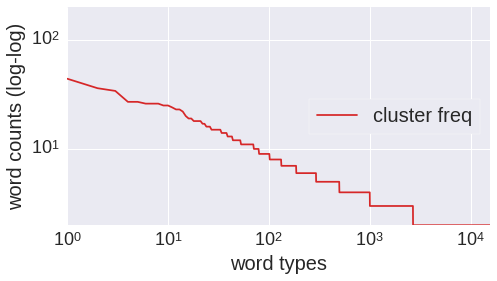

In [53]:
clusters_freq = {cid:len(v) for cid, v in enumerate(clusters_stats['sids'], start=1) \
                 if clusters_stats['purity'][cid-1] >= 0}
plot_word_freq_line(clusters_freq, fig_name="loglog_cluster_id_freq", \
                    label="cluster freq", prefix='c', color=tableau20[6])
# plot_word_freq_line(train_gold_words, fig_name="hehe", prefix='c', color=tableau20[6])
print(len(clusters_freq))

In [54]:
corpus_es_words = []

for fid in align_dict:
    for sid in align_dict[fid]:
         for alist in align_dict[fid][sid]["es"]:
            corpus_es_words.append(alist.word.decode("utf-8").upper())
len(corpus_es_words),len(set(corpus_es_words))
corpus_es_counter = Counter(corpus_es_words)

In [55]:
corpus_word_types = len(corpus_es_counter)
corpus_word_tokens = sum(corpus_es_counter.values())

print("# word types, tokens in entire corpus: {0:d}, {1:d}".format(corpus_word_types, \
                                                                   corpus_word_tokens))

# word types, tokens in entire corpus: 10674, 168195


In [56]:
corpus_en_words = []

for fid in align_dict:
    for sid in align_dict[fid]:
         for alist in align_dict[fid][sid]["en"]:
            corpus_en_words.append(alist.word.decode("utf-8").upper())
len(corpus_en_words),len(set(corpus_en_words))
corpus_en_counter = Counter(corpus_en_words)

In [57]:
corpus_word_types = len(corpus_en_counter)
corpus_word_tokens = sum(corpus_en_counter.values())

print("# word types, tokens in entire corpus: {0:d}, {1:d}".format(corpus_word_types, \
                                                                   corpus_word_tokens))

# word types, tokens in entire corpus: 6723, 159777


In [58]:
clusters_es = {esw: len(clusters_stats['sids'][i]) \
                       for i, esw in enumerate(clusters_stats['most_common']) if esw != ': ('}

clusters_es = {}
for i, esu in enumerate(clusters_stats['most_common']):
    esw = esu.upper()
    if esw != ': (':
        if esw not in clusters_es:
            clusters_es[esw] = [i]
        else:
            clusters_es[esw].append([i])
# print(sum(clusters_es.values()), len(set(clusters_es)))
clusters_es_sorted = sorted([(k,len(v)) for k,v in clusters_es.items()], 
                            reverse=True, key=lambda t:t[1])

In [59]:
print(clusters_es_sorted[:5], clusters_es_sorted[-5:], sep="\n")
clusters_es_cid_corpus_count = [(w,freq, corpus_es_counter[w]) for w, freq in clusters_es_sorted]
out_cols = ["word", "cluster olap", "corpus freq"]
out_rows = []
[out_rows.append(tup) for tup in 
         clusters_es_cid_corpus_count[:10]+clusters_es_cid_corpus_count[-10:]]
clusters_es_cid_corpus_count[:10]
for row in out_rows:
    print(row[0] + " & " + str(row[1]) + " & " + str(row[2]) + " \\\\")
# print "\n".join([" ".join(row) for row in out_rows])
# mini_print(out_cols, out_rows)

[(u'AQU\xcd', 323), (u'BIEN', 271), (u'PUES', 229), (u'VA', 185), (u'SI', 147)]
[(u'ABAJO', 1), (u'CREYENDO', 1), (u'ESCRIBIRNOS', 1), (u'CONTESTARTE', 1), (u'PRINCIPAL', 1)]
AQUÍ & 323 & 606 \\
BIEN & 271 & 1183 \\
PUES & 229 & 1236 \\
VA & 185 & 573 \\
SI & 147 & 1045 \\
DÍA & 135 & 280 \\
BUENO & 127 & 1186 \\
ENTONCES & 124 & 775 \\
TIEMPO & 121 & 193 \\
HACER & 119 & 283 \\
OREJAS & 1 & 3 \\
DARNOS & 1 & 3 \\
DIARIA & 1 & 3 \\
MALAS & 1 & 6 \\
BALDES & 1 & 2 \\
ABAJO & 1 & 18 \\
CREYENDO & 1 & 1 \\
ESCRIBIRNOS & 1 & 1 \\
CONTESTARTE & 1 & 3 \\
PRINCIPAL & 1 & 6 \\


In [60]:
# plot_word_freq(corpus_es_counter, fig_name="hehe", prefix='', num=20, color=tableau20[6])

In [61]:
cid_olap = np.array([v for k,v in clusters_es_sorted])
es_count = np.array([corpus_es_counter[k] for k,v in clusters_es_sorted])

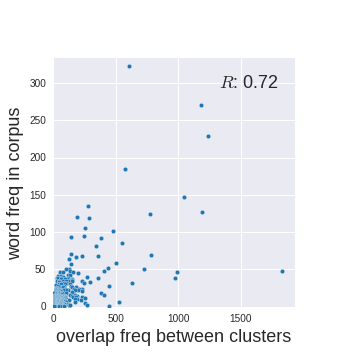

In [62]:
g = sns.JointGrid(x=es_count, y=cid_olap, size=5)
g = g.plot_joint(plt.scatter, color=tableau20[0], s=20, edgecolor="white")
rsquare = lambda a, b: sp.stats.pearsonr(a, b)[0]
g = g.annotate(rsquare, template="{stat}: {val:.2f}", stat="$R$", loc="upper right", fontsize=18)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
plt.gca().set(ylim=(0,np.max(cid_olap)+10))
plt.gca().set(xlim=(0,np.max(es_count)+100))
plt.gca().set_xlabel("overlap freq between clusters", fontsize=18)
plt.gca().set_ylabel("word freq in corpus", fontsize=18)
plt.gcf().tight_layout()
plt.gcf().savefig("cid_corpus_olap.png")

In [63]:
print("Clusters with unique word mappings:")
print(len([1 for i in clusters_es if len(clusters_es[i]) == 1]))
print("Clusters with overlapping word mappings:")
print(sum([len(clusters_es[i]) for i in clusters_es if len(clusters_es[i]) > 1]))
13354 + 121,  1614, len(clusters_es)-1614

Clusters with unique word mappings:
1623
Clusters with overlapping word mappings:
13784


(13475, 1614, 1860)

In [64]:
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [65]:
print(len(clusters_df[clusters_df['same_seg']== True]), len(clusters_df))

449 15533


In [66]:
print(len(clusters_df[clusters_df['cross_seg']== True]), len(clusters_df))

2547 15533


In [67]:
print(len(clusters_df[clusters_df['cross_file']== True]), len(clusters_df))

2547 15533


In [68]:
cross_seg_cids = {s for s, c in enumerate(clusters_stats['cross_seg']) if c == True}

In [69]:
cross_file_cids = {s for s, c in enumerate(clusters_stats['cross_file']) if c == True}

In [70]:
print(len(set(train_pwords) & set(dev_pwords)))
hmm = {int(i) for i in set(train_pwords) & set(dev_pwords)}

2548


### View clusters

In [71]:
view_cols = ['most_common', 'oov', 'purity', 'words', 'depth', 'cross_seg', 'cross_file']

In [72]:
def sid_to_cid_mapping(clusters_stats):
    sid_to_cids = {}
    for cid, sids in enumerate(clusters_stats['sids']):
        for sid in sids:
            if sid not in sid_to_cids:
                sid_to_cids[sid] = set()
            sid_to_cids[sid] |= {cid}
    return sid_to_cids
            

In [73]:
sid_to_cids = sid_to_cid_mapping(clusters_stats)

In [74]:
def get_cids_for_sid(sid, clusters_stats):
    sid_cids = [cid for cid, sids in enumerate(clusters_stats["sids"]) if sid in sids]
    return sid_cids

In [75]:
def find_sids_with_common_pwords(clusters_stats, filter_sids, sid_to_cids):
    check_sids = list(filter_sids)
    sid_overlap = []
    for i in range(len(check_sids)):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(check_sids)) )
        for j in range(i+1, len(check_sids)):
            if check_sids[i] in sid_to_cids and check_sids[j] in sid_to_cids:
                t1 = sid_to_cids[check_sids[i]]
                t2 = sid_to_cids[check_sids[j]]
                if len(t1 & t2) > 0:
                    sid_overlap.append((check_sids[i], check_sids[j], len(t1 & t2), t1&t2))
    return sid_overlap

In [76]:
def find_cids_with_common_sids(clusters_stats, filter_sids):
    cid_overlap = []
    for i in range(len(clusters_stats['sids'])):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(clusters_stats['sids'])) )
        for j in range(i+1, len(clusters_stats['sids'])):
            t1 = set(clusters_stats['sids'][i]) & filter_sids
            t2 = set(clusters_stats['sids'][j]) & filter_sids
            if len(t1 & t2) > 0:
                cid_overlap.append((i, j, len(t1 & t2), t1&t2))
    return cid_overlap

In [77]:
# sid_overlap = find_sids_with_common_pwords(clusters_stats, train_sids, sid_to_cids)

In [78]:
# cid_overlap = find_cids_with_common_sids(clusters_stats, train_sids)

In [79]:
corr = [3, 5, 7]
pred = [5, 10, 15]
gold = [10, 10, 10]
for i in range(3):
    print("%.2f" % (corr[i]/gold[i]), end=" & ")
#     print(corr[i]/pred[i])

0.30 & 0.50 & 0.70 & 

In [80]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(5)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim,in_uttr,x_call,x_uttr
16210,19997,19998,0.999,1,1,0.266667,False,False,True
8637,34387,34388,0.999,1,1,0.095238,False,False,True
598,17526,37544,0.999,1,1,0.047619,False,False,True
14292,58275,58287,0.999,1,1,0.222222,False,False,True
3582,14075,14076,0.999,1,1,1.000000,False,False,True


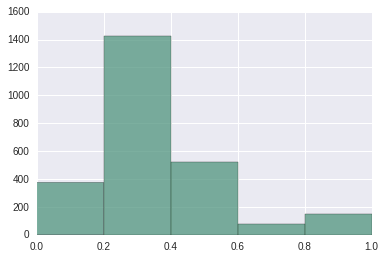

In [81]:
# clusters_df['purity'].hist()
clusters_df.purity[clusters_df.cross_seg == True].hist(alpha=0.5, bins=5)
clusters_df.purity[clusters_df.cross_file == True].hist(alpha=0.5, bins=5)

In [82]:
clusters_stats['avg_purity']

0.33636101254647627

In [83]:
calc_avg_purity(clusters_df)

0.33708209272649936

In [84]:
calc_avg_purity(clusters_df[clusters_df.same_seg])

0.59817671809256667

In [85]:
len(clusters_df[(clusters_df.cross_seg ==  True) & (clusters_df.cross_file == True)])

2547

In [86]:
# calc_avg_purity(clusters_df[(clusters_df.cross_seg == True) & (clusters_df.cross_file == False)])

In [87]:
calc_avg_purity(clusters_df[clusters_df.cross_file])

0.23256818018277325

In [88]:
calc_avg_purity(clusters_df[clusters_df.is_dev]), calc_avg_purity(clusters_df[clusters_df.is_train])

(0.27040074448903623, 0.32817687756199804)

In [89]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

(2547, 15533)

In [90]:
len(clusters_df[clusters_df.is_dev])

3576

In [91]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

1029

## Calculate duration in dev, test, and training sets

In [92]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [93]:
dur = {"tot":{}, "ge500ms":{}}

In [94]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [95]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

Completed calculating durations


In [96]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [97]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 9.565(hrs), dur >= 500ms: 8.527(hrs)
71 71


In [98]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

total dur: 1.788(hrs), dur >= 500ms: 1.584(hrs)
13 13


In [99]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 62, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 62, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 6.841(hrs), dur >= 500ms: 6.104(hrs)
51 51


In [100]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, ts_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, ts_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(ts_dur, ts_dur_500ms))
ts_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(ts_files, len(test_dur_500ms_list))

total dur (hrs) 1.351
total dur (hrs) 1.218
total dur: 1.351(hrs), dur >= 500ms: 1.218(hrs)
20 20


In [101]:
print("Total hrs of speech in Callhome: %.2f (hrs), %.2f (hrs>500ms)" % ((t_dur+d_dur+ts_dur), \
                                                    (t_dur_500ms+d_dur_500ms+ts_dur_500ms)))

Total hrs of speech in Callhome: 9.98 (hrs), 8.91 (hrs>500ms)


In [102]:
# Train subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 62, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 62, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

# Dev subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 81, 84)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 81, 84)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 6.841(hrs), dur >= 500ms: 6.104(hrs)
51 51
total dur: 0.509(hrs), dur >= 500ms: 0.446(hrs)
4 4


### EACL plots

In [103]:
def plot_eacl_results(data_array, plotname="", title=""):
    alpha =  np.arange(1,11,1)
    markers = ["o","v","o","v"]
    labels = ['oracle:optimistic', 'oracle:realistic', 'our model:optimistic', 'our model:realistic']
    colors = [0, 0, 4, 4]
#     linestyles = ['--','--', '-','-']
    linestyles = ['-','--', '-','--']
    
    y_tick_values = [0.05, .2, .4, .6, .8, .9, 1]
    
    fig_size = (9,6)
    fig, ax = plt.subplots(figsize=fig_size)
    for i, arr_data in enumerate(data_array):
        ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
                label=labels[i], markersize=10, linestyle=linestyles[i])
    #ax.yaxis.set_major_locator(MultipleLocator(.05))
    #ax.set_xlabel(r'$K$ predictions per word/pseudoterm', size=28)
    ax.set_xlabel('K predictions per word/pseudoterm', size=28)
    #ax.set_title(plotname, size=20, y=1.02)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.45),
                      ncol=2, fancybox=True, shadow=True, fontsize=20)
    #ax.set_ylabel(title, size=28)
    #ax.set_xticklabels(["{0:0.1f}".format(x) for x in alpha], size=18)
    ax.set_xticklabels(["{0:d}".format(x) for x in alpha], size=24)
    ax.set_xticks(alpha)
    ax.set_yticklabels(["{0:d}%".format(int(y*100.0)) for y in y_tick_values], size=15)
    plt.xticks(rotation=0)
    ax.set_xlim(1,10.5)
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(24)
    
#     for label in ax.get_yticklabels()[::]:
#         label.set_visible(False)
#     ax.get_yticklabels()[-1].set_visible(True)
    
    ax.yaxis.set_ticks(np.array(y_tick_values))
    ax.set_ylim(0,np.max(data_array)+.05)
    
    fig.tight_layout()
    if plotname:
        fig.savefig(plotname, format='png', dpi=300)
#         fig.savefig(plotname.replace("png","pdf"), format='pdf')
    

In [104]:
gold_seg_train_prec = \
    np.array([0.4776, 0.4147, 0.3731, 0.3438, 0.3217, 0.3032, 0.2881, 0.2748, 0.2635, 0.2543])
gold_seg_train_rec = \
    np.array([.4719, 0.6398, 0.7163, 0.7626, 0.7930, 0.8115, 0.8262, 0.8338, 0.8409, 0.8483])
gold_seg_dev_prec = \
    np.array([0.3866, 0.3277, 0.2865, 0.2629, 0.2462, 0.2326, 0.2216, 0.2108, 0.2021, 0.1958])
gold_seg_dev_rec = \
    np.array([.3384, 0.4475, 0.4873, 0.5197, 0.5441, 0.5614, 0.5755, 0.5808, 0.5872, 0.5952])
pseudo_seg_train_prec = \
    np.array([0.4217, 0.3884, 0.3671, 0.3498, 0.3351, 0.3222, 0.3103, 0.2994, 0.2898, 0.2813])
pseudo_seg_train_rec = \
    np.array([.1839, 0.3017, 0.3914, 0.4612, 0.5143, 0.5543, 0.5838, 0.6051, 0.6215, 0.6338])
pseudo_seg_dev_prec = \
    np.array([0.0789, 0.0710, 0.0643, 0.0628, 0.0588, 0.0562, 0.0544, 0.0537, 0.0526, 0.0512])
pseudo_seg_dev_rec = \
    np.array([.0185, 0.0307, 0.0388, 0.0472, 0.0518, 0.0556, 0.0590, 0.0626, 0.0650, 0.0664])
#               0.0182, 0.0305, 0.0385, 0.0470, 0.0519, 0.0562, 0.0594, 0.0628, 0.0657, 0.0681

gold_call_train_prec = \
    np.array([0.4753, 0.4118, 0.3704, 0.3414, 0.3180, 0.2993, 0.2838, 0.2712, 0.2603, 0.2513])
gold_call_train_rec = \
    np.array([.4704, 0.6396, 0.7198, 0.7648, 0.7895, 0.8079, 0.8209, 0.8331, 0.8427, 0.8500])
gold_call_dev_prec = \
    np.array([0.3572, 0.3069, 0.2701, 0.2494, 0.2315, 0.2174, 0.2082, 0.1986, 0.1929, 0.1878])
gold_call_dev_rec = \
    np.array([.2839, 0.3802, 0.4179, 0.4478, 0.4639, 0.4762, 0.4897, 0.4967, 0.5096, 0.5184])
pseudo_call_train_prec = \
    np.array([0.4223, 0.3882, 0.3669, 0.3500, 0.3350, 0.3222, 0.3105, 0.2995, 0.2895, 0.2812])
pseudo_call_train_rec = \
    np.array([.1854, 0.3044, 0.3950, 0.4659, 0.5185, 0.5590, 0.5891, 0.6104, 0.6261, 0.6385])
pseudo_call_dev_prec = \
    np.array([0.0401, 0.0343, 0.0298, 0.0277, 0.0273, 0.0267, 0.0254, 0.0247, 0.0252, 0.0257])
pseudo_call_dev_rec = \
    np.array([.0058, 0.0093, 0.0114, 0.0133, 0.0154, 0.0170, 0.0177, 0.0184, 0.0198, 0.0210])

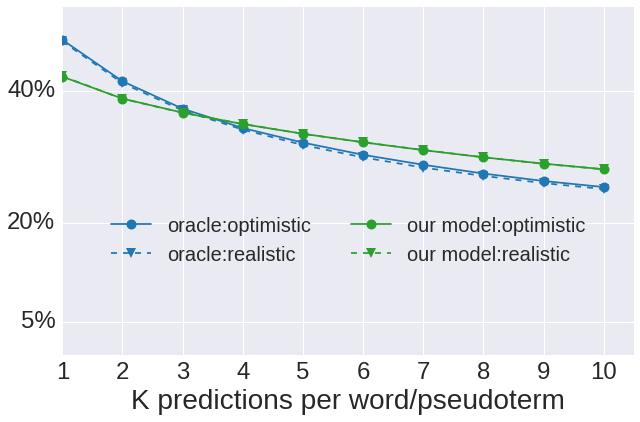

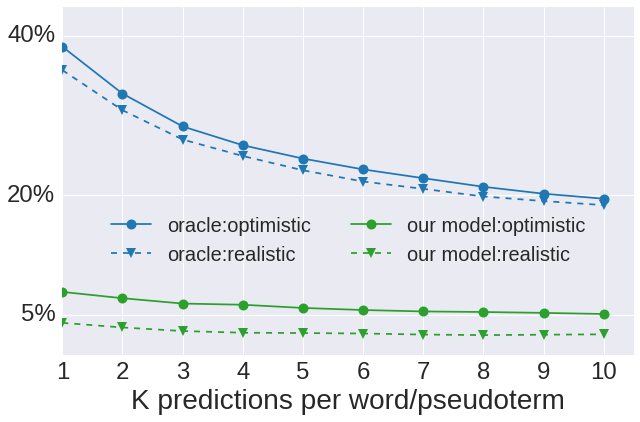

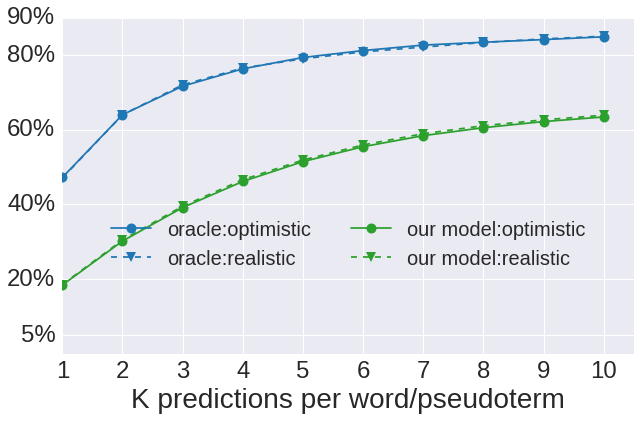

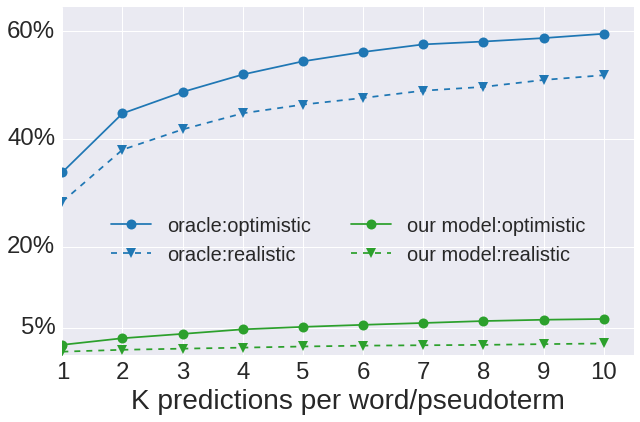

In [105]:
p_train = [gold_seg_train_prec, gold_call_train_prec, pseudo_seg_train_prec, pseudo_call_train_prec]
p_dev = [gold_seg_dev_prec, gold_call_dev_prec, pseudo_seg_dev_prec, pseudo_call_dev_prec]

r_train = [gold_seg_train_rec, gold_call_train_rec, pseudo_seg_train_rec, pseudo_call_train_rec]
r_dev = [gold_seg_dev_rec, gold_call_dev_rec, pseudo_seg_dev_rec, pseudo_call_dev_rec]

titles = ["precision", "precision", "recall", "recall"]
plot_names = ["p_train.png", "p_dev.png", "r_train.png", "r_dev.png"]
all_arrays = [p_train, p_dev, r_train, r_dev]
# all_arrays = [p_dev, r_dev]
for i, data_array in enumerate(all_arrays):
    plot_eacl_results(data_array, plotname=plot_names[i], title=titles[i])

In [106]:
p_r_cols = ['metric', 'model', r'$@K=1$', r'$@K=5$']
p_r_rows = []
models = ['gold:seg', 'gold:call', 'pseudo:seg', 'pseudo:call']
for i, p in enumerate(p_dev):
    p_r_rows.append(["prec", models[i]] + map(lambda v: "{0:.2f}\\%".format(v*100.0), p[[0, 4]]))

for i, r in enumerate(r_dev):
    p_r_rows.append(["rec", models[i]] + map(lambda v: "{0:.2f}\\%".format(v*100.0), r[[0, 4]]))

mini_print(p_r_cols, p_r_rows)

metric & model & $@K=1$ & $@K=5$
prec & gold:seg & 38.66\% & 24.62\%
prec & gold:call & 35.72\% & 23.15\%
prec & pseudo:seg & 7.89\% & 5.88\%
prec & pseudo:call & 4.01\% & 2.73\%
rec & gold:seg & 33.84\% & 54.41\%
rec & gold:call & 28.39\% & 46.39\%
rec & pseudo:seg & 1.85\% & 5.18\%
rec & pseudo:call & 0.58\% & 1.54\%
+--------+-------------+---------+---------+
| metric |    model    |  $@K=1$ |  $@K=5$ |
+--------+-------------+---------+---------+
|  prec  |   gold:seg  | 38.66\% | 24.62\% |
|  prec  |  gold:call  | 35.72\% | 23.15\% |
|  prec  |  pseudo:seg |  7.89\% |  5.88\% |
|  prec  | pseudo:call |  4.01\% |  2.73\% |
|  rec   |   gold:seg  | 33.84\% | 54.41\% |
|  rec   |  gold:call  | 28.39\% | 46.39\% |
|  rec   |  pseudo:seg |  1.85\% |  5.18\% |
|  rec   | pseudo:call |  0.58\% |  1.54\% |
+--------+-------------+---------+---------+


In [107]:
p_r_cols = ['metric', 'gold:seg', 'gold:call', 'pseudo:seg', 'pseudo:call']
p_r_rows = []
models = []

p_1_vals = [p_dev[i][0] for i in range(len(p_dev))]
# p_1_vals, map(lambda v: "{0:.2f}\\%".format(v*100.0), p_1_vals)
p_r_rows.append(["prec $@K=1$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), p_1_vals))

r_1_vals = [r_dev[i][0] for i in range(len(r_dev))]
p_r_rows.append(["rec $@K=1$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), r_1_vals))

p_5_vals = [p_dev[i][4] for i in range(len(p_dev))]
p_r_rows.append(["prec $@K=5$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), p_5_vals))

r_5_vals = [r_dev[i][4] for i in range(len(r_dev))]
p_r_rows.append(["rec $@K=5$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), r_5_vals))


mini_print(p_r_cols, p_r_rows)

metric & gold:seg & gold:call & pseudo:seg & pseudo:call
prec $@K=1$ & 38.66\% & 35.72\% & 7.89\% & 4.01\%
rec $@K=1$ & 33.84\% & 28.39\% & 1.85\% & 0.58\%
prec $@K=5$ & 24.62\% & 23.15\% & 5.88\% & 2.73\%
rec $@K=5$ & 54.41\% & 46.39\% & 5.18\% & 1.54\%
+-------------+----------+-----------+------------+-------------+
|    metric   | gold:seg | gold:call | pseudo:seg | pseudo:call |
+-------------+----------+-----------+------------+-------------+
| prec $@K=1$ | 38.66\%  |  35.72\%  |   7.89\%   |    4.01\%   |
|  rec $@K=1$ | 33.84\%  |  28.39\%  |   1.85\%   |    0.58\%   |
| prec $@K=5$ | 24.62\%  |  23.15\%  |   5.88\%   |    2.73\%   |
|  rec $@K=5$ | 54.41\%  |  46.39\%  |   5.18\%   |    1.54\%   |
+-------------+----------+-----------+------------+-------------+


In [108]:
[r_dev[i][0] for i in range(len(r_dev))]

[0.33839999999999998,
 0.28389999999999999,
 0.018499999999999999,
 0.0057999999999999996]

## Review translations

In [109]:
K = 5
PRED_NUM = 10
MATCH_NUM = 10

In [110]:
import heapq
import textwrap

def get_top_segs(eval_dict, num=10, reverse=False):
    eval_list = [(s, eval_dict[s]['cp']/eval_dict[s]['t']) for s in eval_dict if "." in s \
                if eval_dict[s]['tp'] > 0 and eval_dict[s]['t'] >= 3]
    
    return sorted(eval_list, reverse= not(reverse), key=lambda t:t[1])[:num]
#     if reverse:
#         return heapq.nsmallest(num, eval_list, key=lambda t:t[1])
#     else:
#         return heapq.nlargest(num, eval_list, key=lambda t:t[1])
    

In [111]:
# %%timeit -r1 -n1
best_preds = get_top_segs(mt_pseudo_eval_dict['dev'][K], num=PRED_NUM)
best_oracle_preds = get_top_segs(mt_gold_eval_dict['dev'][K], num=PRED_NUM)
bad_preds = get_top_segs(mt_pseudo_eval_dict['dev'][K], reverse=True, num=PRED_NUM)

In [112]:
def display_oracle_preds(pred_list, align_dict, pred_dict):
    out_cols = ["gold", "oracle pred"]
    out_rows = []
    for i, pred in enumerate(pred_list):
        sid = pred[0]
#         ref_es_words = get_en_words(align_dict, sid, "es")
#         ref_es_cnt_words = get_en_words(align_dict, sid, "es_cnt")
        
        ref_en_words = get_en_words(align_dict, sid, "en")
        ref_en_cnt_words = get_en_words(align_dict, sid, "en_cnt")
        
        p_en_words = pred_dict[sid]
        p_en_words = [(r"%s" % w) if \
                      w in nltk.corpus.stopwords.words("english") else w  for w in p_en_words]
#         c_words = set(ref_en_words) & set(p_en_words)
        
#         ref_es_words = [(r"\uline{%s}" % w) if w in c_words else w for w in ref_en_words]
#         ref_es_words = [(r"\noindent{{\color{lightgray} %s}}" % w) if w not in ref_es_cnt_words else w \
#                         for w in ref_es_words]
        ref_en_words = [(r"%s" % w) if w not in ref_en_cnt_words and "uline" not in w else w \
                        for w in ref_en_words]
        
#         p_en_words = [(r"\uline{%s}" % w) if w in c_words else w for w in p_en_words]
#         out_rows.append([str(i+1), " ".join(ref_es_words).lower(), " ".join(ref_en_words).lower(), 
#                          " ".join(p_en_words).lower() + " \\\\"])
        out_rows.append([" ".join(ref_en_words).lower(), " ".join(p_en_words).lower() + " \\\\"])
#         print(ref_en_cnt_words)
    mini_print(out_cols, out_rows)

In [113]:
def display_preds(pred_list, align_dict, pred_dict):
    out_cols = ["gold trans", "gold pred", "model pred"]
    out_rows = []
    for i, pred in enumerate(pred_list):
        sid = pred[0]
        ref_es_words = get_en_words(align_dict, sid, "es")
        ref_es_cnt_words = get_en_words(align_dict, sid, "es_cnt")
        
        ref_en_words = get_en_words(align_dict, sid, "en")
        ref_en_cnt_words = get_en_words(align_dict, sid, "en_cnt")
        
        p_en_words = pred_dict[sid]
        c_words = set(ref_en_words) & set(p_en_words)
        
#         ref_es_words = [(r"\uline{%s}" % w) if w in c_words else w for w in ref_en_words]
        ref_es_words = [(r"\noindent{{\color{lightgray} %s}}" % w) if w not in ref_es_cnt_words else w \
                        for w in ref_es_words]
        
        ref_en_words = [(r"\uline{%s}" % w) if w in c_words else w for w in ref_en_words]
        ref_en_words = [(r"\noindent{{\color{lightgray} %s}}" % w) if w not in ref_en_cnt_words and "uline" not in w else w \
                        for w in ref_en_words]
        
        p_en_words = [(r"\uline{%s}" % w) if w in c_words else w for w in p_en_words]
#         out_rows.append([str(i+1), " ".join(ref_es_words).lower(), " ".join(ref_en_words).lower(), 
#                          " ".join(p_en_words).lower() + " \\\\"])
        out_rows.append([" ".join(ref_es_words).lower(), " ".join(ref_en_words).lower(), 
                         " ".join(p_en_words).lower() + " \\\\"])
#         print(ref_en_cnt_words)
    mini_print(out_cols, out_rows)

In [114]:
# display_preds(best_preds, align_dict, mt_pseudo_pred_dict[K])

In [115]:
# display_oracle_preds(best_preds, align_dict, mt_gold_pred_dict[K])

In [116]:
# display_preds(bad_preds, align_dict, mt_pseudo_pred_dict[K])

In [117]:
# dev_sids

In [118]:
def get_top_matched_words(align_dict, pred_list, sid_list, num=10, reverse=False):
    
    dev_en_gold = []
    dev_en_remain = []
    
#     for i, sid in enumerate([s for s in pred_list if s in sid_list]):
    for i, sid in enumerate(sid_list):
        gold_seg_en = get_en_words(align_dict, sid, "en_cnt")
        dev_en_gold.extend(gold_seg_en)
        for pred_word in pred_list[sid]:
            if pred_word in gold_seg_en:
                gold_seg_en.remove(pred_word)
        dev_en_remain.extend(gold_seg_en)

    dev_en_gold_counter = Counter(dev_en_gold)
    dev_en_remain_counter = Counter(dev_en_remain)
    
    return dev_en_gold_counter, dev_en_remain_counter


In [119]:
# %%timeit -r1 -n1
dev_en_gold_counter, dev_en_remain_counter = \
            get_top_matched_words(align_dict, pred_list=mt_pseudo_pred_dict[K], \
                                  sid_list=dev_sids, num=PRED_NUM)

In [120]:
len(train_sids), len(dev_sids), 214/8094 * 100

(13137, 2476, 2.6439337781072396)

In [121]:
tot = sum(dev_en_gold_counter.values())
rem = sum(dev_en_remain_counter.values())
rec = (tot-rem) / tot * 100
print("{0:.3f} %".format(rec))

2.761 %


In [122]:
es_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es']]
es_cnt_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es_cnt']]
en_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en']]
en_cnt_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en_cnt']]

In [123]:
es_words_freq = Counter(es_words)
es_cnt_words_freq = Counter(es_cnt_words)
en_words_freq = Counter(en_words)
en_cnt_words_freq = Counter(en_cnt_words)

In [124]:
dev_en_match_counter = (dev_en_gold_counter-dev_en_remain_counter)

In [125]:
total_predictions = 0
dev_pred_words = []
for sid, p in mt_pseudo_pred_dict[K].items():
    if sid in dev_sids:
        total_predictions += len(p)
        dev_pred_words.extend(p)
print(total_predictions)

dev_pred_counter = Counter(dev_pred_words)
print(sum(dev_pred_counter.values()))

11078
11078


In [126]:
mt_pseudo_eval_dict['dev'][K]['t'], \
mt_pseudo_eval_dict['dev'][K]['tp'], \
mt_pseudo_eval_dict['dev'][K]['cp']

(11589, 11078, 320)

In [127]:
total_gold_words = sum(dev_en_gold_counter.values())
total_matched_words = sum(dev_en_match_counter.values())
print("{0:30s} | {1:d}".format("total content words:", total_gold_words))
print("{0:30s} | {1:d}".format("total words predicted:", total_predictions))
print("{0:30s} | {1:d}".format("predicted words which match:", total_matched_words))
print("-"*80)
# print(total_matched_words/total_gold_words)

total content words:           | 11589
total words predicted:         | 11078
predicted words which match:   | 320
--------------------------------------------------------------------------------


In [128]:
top_words_in_gold = ([w for w, freq in sorted(dev_en_gold_counter.items(), reverse=True, key=lambda t:t[1])])

In [153]:
K_MOST_FREQ = 50
print("{0:10s} | {1:>10s} | {2:>10s} | {3:>10s}".format("word", "corr pred", "tot pred", "tot gold"))
pred_k_sum = 0
pred_k_corr_sum = 0
pred_k_gold = 0
for w in top_words_in_gold[:K_MOST_FREQ]:
    print("{0:10s} | {1:10d} | {2:10d} | {3:10d}".format(w, dev_en_match_counter[w], \
                                                         dev_pred_counter[w], dev_en_gold_counter[w]))
    pred_k_sum += dev_pred_counter[w]
    pred_k_corr_sum += dev_en_match_counter[w]
    pred_k_gold += dev_en_gold_counter[w]
#     pred_gold_ratio = pred_k_sum / pred_k_gold * 100
    pred_gold_ratio = pred_k_sum / total_gold_words * 100
    corr_pred_ratio = pred_k_corr_sum / pred_k_sum * 100
    corr_most_freq_ratio = pred_k_corr_sum / total_matched_words * 100

print("-"*80)
print("{0:50s} | {1:d}".format("frequency of top {0:d} words in gold:".format(K_MOST_FREQ), pred_k_gold))
print("{0:50s} | {1:d}".format("frequency of top {0:d} words in predictions:".format(K_MOST_FREQ), pred_k_sum))
print("{0:50s} | {1:d}".format("num of top {0:d} words correct in predictions:".format(K_MOST_FREQ), pred_k_corr_sum))
    
print("-"*80)
print("Top {0:d} most frequent words frequency ratio in gold = {1:.3f}%".format(K_MOST_FREQ, 
                                                                                     pred_gold_ratio))

print("% of words in prediction which are {0:d} most frequent in gold = {1:.3f}%".format(K_MOST_FREQ, 
                                                                                     corr_pred_ratio))

print("% of words in prediction which are correct and {0:d} most frequent = {1:.3f}%".format(K_MOST_FREQ, 
                                                                                     corr_most_freq_ratio))

print(pred_k_sum, pred_k_corr_sum, pred_k_gold)
print(pred_k_sum / total_gold_words * 100)

word       |  corr pred |   tot pred |   tot gold
YES        |         19 |        136 |        434
'T         |         56 |        241 |        352
'S         |         16 |        203 |        237
WELL       |         18 |        184 |        235
AH         |          2 |         96 |        176
OH         |          1 |         88 |        170
KNOW       |          7 |         94 |        159
SEE        |          2 |         85 |        138
YEAH       |          0 |         47 |        137
RIGHT      |          4 |         69 |        113
OKAY       |          3 |         49 |        108
LIKE       |          6 |        116 |        106
SURE       |          3 |         47 |         96
TELL       |          4 |         37 |         96
AHA        |          0 |          9 |         89
TOLD       |          2 |         34 |         87
GOING      |          7 |         78 |         83
DIDN       |          1 |         34 |         79
'LL        |          4 |         55 |         78


In [148]:
dev_en_match_dict = {w:(dev_en_match_counter[w],dev_en_gold_counter[w]) for w in dev_en_gold_counter}

In [149]:
sorted_dev_en_match = sorted([(w.lower(),v[0],v[1], en_cnt_words_freq[w]) for w,v in dev_en_match_dict.items()], \
                             reverse=True, key=lambda t:t[1]/t[2])

In [151]:
mini_print(["word", "match", "tot", "freq"], \
           sorted_dev_en_match[:50])

word & match & tot & freq
help & 1 & 1 & 34
bedroom & 1 & 1 & 6
funeral & 1 & 1 & 2
philadelphia & 1 & 2 & 15
united & 3 & 6 & 52
government & 1 & 2 & 11
tests & 1 & 2 & 10
spanish & 1 & 2 & 35
word & 1 & 2 & 14
recommended & 1 & 2 & 5
inside & 1 & 2 & 19
states & 3 & 7 & 46
bus & 1 & 3 & 18
use & 1 & 3 & 31
everyone & 1 & 4 & 67
hopefully & 1 & 4 & 21
worried & 1 & 4 & 28
december & 1 & 4 & 54
married & 2 & 8 & 52
computers & 1 & 4 & 19
either & 1 & 4 & 30
seventy & 1 & 4 & 22
caracas & 1 & 4 & 23
life & 2 & 9 & 52
sad & 1 & 5 & 19
spent & 1 & 5 & 24
fax & 1 & 5 & 28
buying & 1 & 5 & 10
company & 2 & 11 & 34
bit & 2 & 11 & 82
money & 4 & 24 & 178
person & 1 & 6 & 39
trip & 1 & 6 & 46
spoke & 1 & 6 & 43
school & 1 & 6 & 84
't & 56 & 352 & 2265
problem & 2 & 14 & 106
besides & 1 & 7 & 53
hard & 2 & 15 & 66
maybe & 2 & 15 & 207
called & 5 & 38 & 255
never & 1 & 8 & 98
make & 1 & 8 & 90
months & 1 & 8 & 98
wanted & 1 & 8 & 105
twelve & 1 & 8 & 37
lot & 3 & 25 & 229
another & 2 & 17 & 137


In [146]:
mini_print(["word", "match", "tot", "freq"], \
           sorted_dev_en_match[-MATCH_NUM:])

word & match & tot & freq
philadelphia & 1 & 2 & 15
government & 1 & 2 & 11
tests & 1 & 2 & 10
spanish & 1 & 2 & 35
word & 1 & 2 & 14
recommended & 1 & 2 & 5
inside & 1 & 2 & 19
help & 1 & 1 & 34
bedroom & 1 & 1 & 6
funeral & 1 & 1 & 2
+--------------+-------+-----+------+
|     word     | match | tot | freq |
+--------------+-------+-----+------+
| philadelphia |   1   |  2  |  15  |
|  government  |   1   |  2  |  11  |
|    tests     |   1   |  2  |  10  |
|   spanish    |   1   |  2  |  35  |
|     word     |   1   |  2  |  14  |
| recommended  |   1   |  2  |  5   |
|    inside    |   1   |  2  |  19  |
|     help     |   1   |  1  |  34  |
|   bedroom    |   1   |  1  |  6   |
|   funeral    |   1   |  1  |  2   |
+--------------+-------+-----+------+


In [141]:
sorted_dev_en_match = sorted([(w.lower(),v[0],v[1], en_cnt_words_freq[w]) for w,v in dev_en_match_dict.items() if v[0] > 0], \
                             reverse=True, key=lambda t:t[2])

In [142]:
mini_print(["word", "match", "tot", "freq"], \
           sorted_dev_en_match[:MATCH_NUM])

word & match & tot & freq
yes & 19 & 434 & 3345
't & 56 & 352 & 2265
's & 16 & 237 & 2030
well & 18 & 235 & 1829
ah & 2 & 176 & 1349
oh & 1 & 170 & 1066
know & 7 & 159 & 1100
see & 2 & 138 & 934
right & 4 & 113 & 790
okay & 3 & 108 & 734
+-------+-------+-----+------+
|  word | match | tot | freq |
+-------+-------+-----+------+
|  yes  |   19  | 434 | 3345 |
|   't  |   56  | 352 | 2265 |
|   's  |   16  | 237 | 2030 |
|  well |   18  | 235 | 1829 |
|   ah  |   2   | 176 | 1349 |
|   oh  |   1   | 170 | 1066 |
|  know |   7   | 159 | 1100 |
|  see  |   2   | 138 | 934  |
| right |   4   | 113 | 790  |
|  okay |   3   | 108 | 734  |
+-------+-------+-----+------+


In [122]:
sum(dev_en_match_counter.values())

126

In [123]:
" ".join([w.lower() for w in dev_en_match_counter])

'funny bottles knowledge people explain back truth stores strength chinese say movement week apartment yeah brazilian go party school aha look oh money water yes yet twelve code says palace susan four going november hundred find happy modem exactly sick around geraldine five said days mom mexico sure know works work think see weather ask hasn knoxville number need argentina come like thirty twenty yesterday \xc2\xb4 matter hi tell monday boston honorary two understand lot university well one policy called told monterrey good okay ah study thing computer teeth tomorrow right vice make salta call buckets bought'

In [124]:
" ".join([w.lower() for w in \
          set(dev_en_gold_counter.keys())-set(dev_en_match_counter.keys())][:217])

'ago grown life everyone buddy spite text age later dramatic environment courses strange thanks fall growing killing dedicated furrow among sister printer last ringing tells hmm things tinso platelets concrete thermal much honestly stays aunt cases dress santi maria saying six raining grabbing kisses fix foam anyway least hand kiko caress pesos sweet phone weird bye venezuela stitches beautiful catholic staying gets specially visiting may house review accent telephone comfortable person near traveling uncle vacations telling law structures realize happiness man great used destiny psychiatrist movie expense friday ximena tests fucked defender guy invented eh arrives doctor painted company huh denver manuelita talking camera arrived something pays starting wow western sending lazy necessarily paris thousand responsible dude else ridden put woman baby christian agree cool envelope try tumour ma lies mm saved uhm lessen gonna public traffic listening pictures degrees pulled ina swim august

In [125]:
[w.word for w in align_dict['001']['001.001']['es_cnt']]

['MECHITA', 'MANDADO', 'QUI\xc3\xa9N', 'POCHO']

In [132]:
es_w_set = []
en_w_set = []
for seg in train_sids:
    es_w_set.extend(gold_feats_dict[seg])
    en_w_set.extend(get_en_words(align_dict, seg, 'en_cnt'))
    

No content word found in 038.039 segment
No content word found in 011.194 segment
No content word found in 057.023 segment
No content word found in 062.202 segment
No content word found in 010.170 segment
No content word found in 053.135 segment
No content word found in 006.178 segment
No content word found in 053.191 segment
No content word found in 084.094 segment
No content word found in 111.184 segment
No content word found in 045.091 segment
No content word found in 084.165 segment
No content word found in 114.127 segment
No content word found in 060.082 segment
No content word found in 005.148 segment
No content word found in 063.171 segment
No content word found in 061.175 segment
No content word found in 007.178 segment
No content word found in 060.041 segment
No content word found in 088.141 segment
No content word found in 115.149 segment
No content word found in 085.105 segment
No content word found in 043.049 segment
No content word found in 044.054 segment
No content word 

In [133]:
print(len(es_w_set), len(set(es_w_set)))
print(len(en_w_set), len(set(en_w_set)))
    

63129 9309
63555 5980


In [135]:
A = []
A.extend(gold_feats_dict['111.111'])

In [136]:
A

['SALUDARLA', 'LLAM\xc3\xb3', 'AH']

In [137]:
align_dict["081"]["081.002"]["es"]

[Align(word='OKEY', start=12, end=56),
 Align(word='QU\xc3\xa9DENSE', start=136, end=159),
 Align(word='EL', start=159, end=165),
 Align(word='EL', start=165, end=171),
 Align(word='MIAMI', start=171, end=202),
 Align(word='DADE', start=202, end=218),
 Align(word='YO', start=266, end=278),
 Align(word='PUEDE', start=278, end=296),
 Align(word='QUE', start=296, end=307),
 Align(word='BAJE', start=307, end=332),
 Align(word='ENTONCES', start=332, end=369)]

### EACL Talk

In [12]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+------------------------+---------------------------------------------------+
| pair id |  nid  |     ES transcript      |                   EN translation                  |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19997 | CINCO OCHO CUATRO SEIS |                FIVE EIGHT FOUR SIX                |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19998 | CINCO OCHO CUATRO SEIS | EH SEE FOUR THE ONLY THING WANT KNOW IS THAT THAT |
|         |       |                        |   THE PHONE IS RIGHT FOUR EIGHT THREE FIVE EIGHT  |
|         |       |                        |  FOUR SIX IS THE MOST IMPORTANT THING BECAUSE THE |
|         |       |                        |                  WASHINGTON CODE                  |
+---------+-------+------------------------+---------------------------------------------------+


In [82]:
segid = nodes_dict[19997].seg
segid = '114.134'
seg_wav = gen_seg_wav(segid, utd_wavs_path, es_merge_wavs_path, segment_map)
print(seg_wav)
Audio(seg_wav)

../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/wavs/wavs/114.134.wav


In [102]:
def plot_seg_wav(segid):
    seg_wav = gen_seg_wav(segid, utd_wavs_path, es_merge_wavs_path, segment_map)
    fig = plt.figure()
    fig.set_size_inches(20, 1)
    ax = fig.add_subplot(111)
    sr, wav_data = scipy.io.wavfile.read(seg_wav)
    wav_data = (wav_data - wav_data.mean()) / wav_data.std()
    ax.plot(wav_data[:len(wav_data)//1], c=tableau20[0])
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_visible(False)

    print(" ".join([w.word.lower() for w in align_dict[segid.split('.')[0]][segid]['es']]))
    print(" ".join([w.word.lower() for w in align_dict[segid.split('.')[0]][segid]['en']]))

43781 44336
sí pues vaya está bueno y seguís y qué tal vas con la corrida bien
yes well that 's good and so and how 's going with the running good
47684 48103
sí pues y el carrito felicitaciones por el carro ya me contaron
yes well and the car congratulations for the car already told me
9812 10475
o sea él le llama del trabajo mi papá le llama del trabajo así es que no se han con el de contacto <noise>
so so he call him from work my dad calls him from work so so they have not lost the contact
22476 23034
imagínese si a mi papá le sale esta co este trabajo y se tiene que ir a perú y tendríamos que irnos por dos años
go figure if my dad gets gets this job and he has to go to peru would have to go for two years


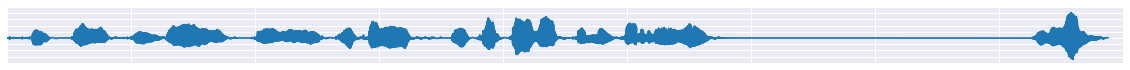

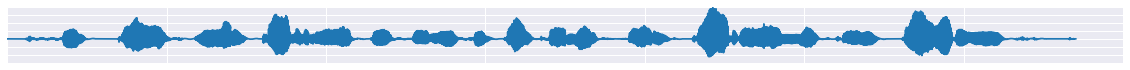

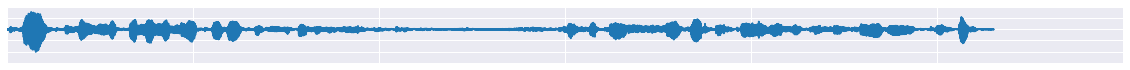

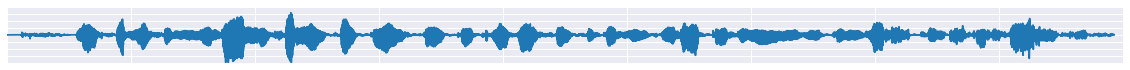

In [114]:
eacl_segids = ['114.134', '114.142', '091.044', '091.107']

for segid in eacl_segids:
    plot_seg_wav(segid)

In [95]:
utd_wavs_path

u'../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/wavs'

In [42]:
display(gen_node_wav(19997, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [36]:
freq_words = [w for w in clusters_stats['most_common']]

In [37]:
freq_words_cntr = Counter(freq_words)

In [42]:
print("\n".join([w[0] for w in freq_words_cntr.most_common(5)]))

aquí
bien
pues
va
si


In [131]:
clusters_stats.keys()

['fids', 'avg_purity', 'sids', 'purity', 'words', 'most_common']

In [43]:
print(" ,".join([str(i) for i, w in enumerate(clusters_stats['most_common']) if w == u'trabajo' and 
 clusters_stats['purity'][i] >= 0.0 and clusters_stats['purity'][i] <= 1]))
print(len([str(i) for i, w in enumerate(clusters_stats['most_common']) if w == u'bien' and 
 clusters_stats['purity'][i] >= 0.0 and clusters_stats['purity'][i] <= 1]))

288 ,312 ,920 ,1503 ,1584 ,1701 ,2205 ,2443 ,2739 ,2917 ,2935 ,2987 ,2996 ,3455 ,5053 ,5198 ,5209 ,6075 ,6244 ,6441 ,7872 ,8026 ,8275 ,8388 ,8576 ,8662 ,9789 ,11098 ,11105 ,11121 ,11129 ,11699 ,13323 ,13382 ,13599 ,13744 ,14475
271


In [145]:
" ,".join([str(i) for i, w in enumerate(clusters_stats['most_common']) if w == 'pues' and 
 len(set(clusters_stats['sids'][i]) & set(eacl_segids)) > 0])

'412 ,2358 ,6290 ,12221'

In [128]:
!ls ../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/

clusters.p			mt_corpus_train_pseudo.bi
clusters_stats.dict		mt_gold_eval_dict.p
eval.p				mt_gold_pred_dict.p
master_graph.clusters		mt_probs_dict_gold.p
master_graph.dedups		mt_probs_dict_pseudo.p
master_graph.edges		mt_probs_gold.txt
master_graph.nodes		mt_probs_pseudo.txt
master_graph.olapedges		mt_pseudo_eval_dict.p
master_graph_pairs_debug.match	mt_pseudo_pred_dict.p
master_graph.segnodes		nodes_dict.p
master_graph.vedges		pseudowords.dict
master_graph.zclusters		pseudowords.feats
master_graph.zedges		score_pairs.p
master_match			wavs
mt_corpus_train_gold.bi


In [48]:
cid=288
# cid = 10758
cid_fname = play_cluster(cid)
print(cid_fname)
print(clusters_stats['sids'][cid])
Audio(cid_fname)
print(", ".join(clusters_stats['words'][cid]))
print(clusters_stats['purity'][cid])

../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/tmpwav/0289.wav
['002.061', '050.066', '114.155', '076.114', '091.107', '025.092', '091.044', '114.134', '100.129', '101.082', '110.139']
siete, días, haití, cómo, gracias, besote, trabajo, trabajo, trata, llama, trabajo, tal, vas, llave, pongo, queridos, poquito
0.176470588235


In [39]:
cid_fname = play_cluster(cid=14581)
print(cid_fname)
Audio(cid_fname)

../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/tmpwav/14582.wav


In [168]:
show_translation_prob("289", pseudo_probs_dict)

translation probability table for 289
prob sum: 0.4797
en word & prob
job & 1.0000
+---------+--------+
| en word |  prob  |
+---------+--------+
|   job   | 1.0000 |
+---------+--------+


In [117]:
clusters_stats.keys()

['train_depth',
 'cross_seg',
 'cross_file',
 'dev_depth',
 'fids',
 'avg_purity',
 'sids',
 'in_vocab',
 'same_seg',
 'is_dev',
 'oov',
 'purity',
 'words',
 'most_common',
 'is_train']

In [118]:
[i for i in enumerate(clusters_stats['sids'])]

[(0, ['001.033', '001.033']),
 (1, ['001.084', '001.084']),
 (2, ['001.159', '001.159']),
 (3, ['001.224', '001.224']),
 (4, ['001.249', '001.249']),
 (5, ['001.141', '001.143']),
 (6, ['001.141', '001.143']),
 (7, ['001.001', '001.003', '001.260', '009.096']),
 (8, ['001.229', '001.233', '023.080']),
 (9, ['001.021', '001.027']),
 (10, ['001.027', '001.033']),
 (11, ['001.132', '001.143']),
 (12, ['001.084', '001.096']),
 (13, ['001.023', '001.033']),
 (14, ['001.159', '001.174']),
 (15, ['001.174', '001.185']),
 (16, ['001.212', '001.223']),
 (17, ['001.258', '001.271']),
 (18,
  ['001.229',
   '001.247',
   '078.036',
   '049.190',
   '114.070',
   '066.196',
   '066.042',
   '067.028',
   '060.097',
   '078.119',
   '066.051',
   '119.007']),
 (19, ['001.100', '001.118']),
 (20, ['001.249', '001.267', '001.249', '023.065']),
 (21, ['001.247', '001.267']),
 (22, ['001.148', '001.174']),
 (23, ['001.159', '001.185']),
 (24, ['001.240', '001.270']),
 (25, ['001.216', '001.249']),
 (26

In [122]:
clusters_stats.keys()

['fids', 'avg_purity', 'sids', 'purity', 'words', 'most_common']

## Keywords

In [15]:
align_dict['088']['088.194']['en']

[Align(word='OH', start=3, end=15),
 Align(word='HE', start=113, end=128),
 Align(word='NOW', start=40, end=72),
 Align(word='HAS', start=72, end=99),
 Align(word='NEW', start=128, end=152),
 Align(word='PARTNER', start=152, end=209),
 Align(word='THAT', start=209, end=219),
 Align(word='HAS', start=219, end=241),
 Align(word="'S", start=270, end=278),
 Align(word='A', start=278, end=295),
 Align(word='GRINGO', start=295, end=329),
 Align(word='GRINGO', start=329, end=348),
 Align(word='OH', start=373, end=395)]

## EMNLP

In [139]:
feats_dict['111.121']

['13604']

In [258]:
def get_segment_durations(seg_fname):
    seg_dur_dict = {}
    with open(seg_fname, "r") as seg_f:
        for i, line in enumerate(seg_f):
            if i == 0:
                continue
            try:
                line_items = line.strip().split()
                seg_key = line_items[0]
                if seg_key not in seg_dur_dict:
                    seg_dur_dict[seg_key] = {}
                seg_start = int(float(line_items[6])*100)
                seg_end = int(float(line_items[7])*100)
                seg_dur_dict[seg_key] = (seg_end-seg_start)
            except ValueError:
                print("Incorrect line format at line: %d" % i)
    return seg_dur_dict
            

In [259]:
seg_dur_dict = get_segment_durations('../segments.txt')

In [260]:
seg_dur_dict['001.033']

1042

In [261]:
nodes_dict[2]

Node(file='001', seg='001.033', start=170, end=224, es=('RADIOTERAPISTA',), es_cnt=('RADIOTERAPISTA',))

In [274]:
def generate_durations_for_segments(segment_map, nodes_dict, 
                                    clusters, feats_fname, feats_dict_fname):
    dur_dict = {}
    total_errors = 0
    display_den = len(clusters) // 10
    
    for clid, nodes in enumerate(clusters):
        if clid % display_den == 0:
            print('processing cluster %d out of %d' % (clid, len(clusters)))
        for nid in nodes:
            node = nodes_dict[nid]
            if node.seg not in dur_dict:
                dur_dict[node.seg] = []
            dur_dict[node.seg].append((node.start, node.end))
    
    print("total clusters: %d" % clid)
    # Get complete list of segment ids
    segids = []
    for fid in segment_map:
        segids.extend(segment_map[fid].keys())
    
    for seg_id in sorted(segids):
        # adding -1 for missing pseudotext
        if seg_id not in dur_dict:
            total_errors += 1
            feats_dict[seg_id] = [0]

    print("Psuedowords not found for: %d segments, out of total: %d segments" % 
          (total_errors, len(segids)))
    return dur_dict
    

In [275]:
dur_dict = generate_durations_for_segments(segment_map, nodes_dict, 
                                    clusters, feats_fname, feats_dict_fname)

processing cluster 0 out of 15533
processing cluster 1553 out of 15533
processing cluster 3106 out of 15533
processing cluster 4659 out of 15533
processing cluster 6212 out of 15533
processing cluster 7765 out of 15533
processing cluster 9318 out of 15533
processing cluster 10871 out of 15533
processing cluster 12424 out of 15533
processing cluster 13977 out of 15533
processing cluster 15530 out of 15533
total clusters: 15532
Psuedowords not found for: 8788 segments, out of total: 17394 segments


In [283]:
dur_dict['111.121'], seg_dur_dict['111.121']

([(417, 468)], 540)

In [339]:
def compute_segment_coverage(seg_dur_dict, dur_dict):
    data_coverage = {"total": {"train": 0, "test": 0}, "utd": {"train": 0, "test": 0}}
    seg_coverage_dict = {}
    for segid in seg_dur_dict:
        seg_coverage_dict[segid] = 0
        if segid in dur_dict:
            remaining_units = set(range(seg_dur_dict[segid]))
            for node in dur_dict[segid]:
                curr_unit = set(range(node[0], node[1]+1))
                remaining_units = remaining_units - curr_unit
            seg_coverage_dict[segid] = seg_dur_dict[segid] - len(remaining_units)
            
            
            if segid in train_sids:
                train_test_key = "train"
            elif segid in dev_sids:
                train_test_key = "test"
                
            data_coverage["total"][train_test_key] += seg_dur_dict[segid] / 100.0
            data_coverage["utd"][train_test_key] += seg_coverage_dict[segid] / 100.0
                
    print("finished calculating coverage")
    return seg_coverage_dict, data_coverage

In [340]:
seg_coverage_dict, data_coverage = compute_segment_coverage(seg_dur_dict, dur_dict)

finished calculating coverage


In [341]:
seg_coverage_dict['111.121'], data_coverage

(52,
 {'total': {'test': 8401.979999999987, 'train': 32976.91999999977},
  'utd': {'test': 2513.7299999999955, 'train': 9964.400000000149}})

In [348]:
print("{0:10s} | {1:>10s} hrs | {2:>10s} hrs | {3:>10s} %".format("", 
                                                                  "total", "utd", "" ))
for key in ["train", "test"]:
    tots = data_coverage["total"][key] / 3600
    utd = data_coverage["utd"][key] / 3600
    perc = utd / tots * 100
    print("{0:10s} | {1:10.2f} hrs | {2:10.2f} hrs | {3:10.2f} %".format(key,
                                                                           tots,
                                                                           utd,
                                                                           perc))

           |      total hrs |        utd hrs |            %
train      |       9.16 hrs |       2.77 hrs |      30.22 %
test       |       2.33 hrs |       0.70 hrs |      29.92 %


In [343]:
2.77 / 9.16 * 100, 0.70

30.240174672489083